<a href="https://colab.research.google.com/github/GustavoAlfredoZA/neural-network-notebooks/blob/main/Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Style transfer, Gustavo Alfredo Zárate Acosta

In [ ]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage, Compose, Scale, Resize
import fastai.vision.all as fv
from PIL import Image
import gc
from fastai.callback.hook import hook_outputs
from fastprogress.fastprogress import progress_bar
#from Layers import num_params, Normalize


to_tensor = ToTensor()
to_pil = ToPILImage()

/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:52: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None, :, None, None]
        self.std = torch.tensor(std)[None, :, None, None]

    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [ ]:
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [ ]:
size = (384,256)

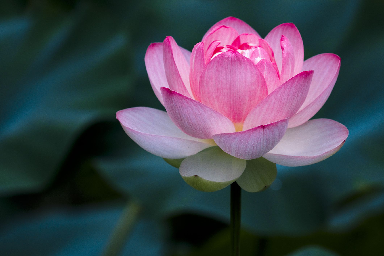

In [ ]:
content_img = fv.PILImage.create("flower_d.jpg").resize(size)
content_img

In [ ]:
content_tensor = Normalize()(to_tensor(content_img)[None])
content_tensor.shape

torch.Size([1, 3, 256, 384])

In [ ]:
def denorm(t):
    mean, sd = (torch.tensor(x) for x in fv.imagenet_stats)
    mean, sd = mean[:, None, None], sd[:, None, None]
    return mean + t*sd

def view(t):
    t = t.detach().cpu()
    if len(t.shape) == 4:
        t = t[0]
    return to_pil(denorm(t).clamp(0,1))

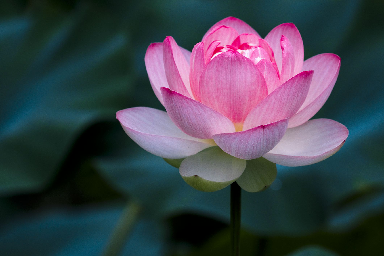

In [ ]:
view(content_tensor)

In [ ]:
content_tensor = content_tensor.cuda()

Crear ruido aleatorio que se va a transformar en la imagen, optimizar los pizeles por eso la gradiente

In [ ]:
noise = torch.randn_like(content_tensor, requires_grad = True)

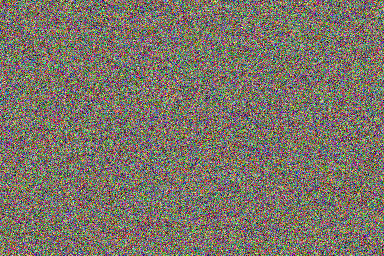

In [ ]:
view(noise)

In [ ]:
optimizer = torch.optim.Adam([noise], lr = 1e-1)

In [ ]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()
    # Por ahora, pensemos que la pérdida será la distancia pixel a pixel a la orighinal
    loss = F.mse_loss(noise,content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    loss.backward()
    optimizer.step()

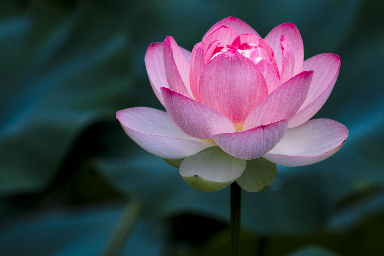

In [ ]:
view(noise)

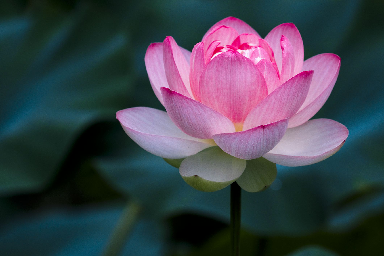

In [ ]:
view(content_tensor)

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, weights = [1, 3, 8, 12, 20, 10]):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.weights = weights
        
    def extract_features(self, x, clone = False):
        self.model(x)
        features = list(self.hooks.stored)
        if clone:
            features = [f.clone() for f in features]    
        return features
    
    def forward(self, x, content_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        return sum([F.mse_loss(a, b)*w for a, b, w in zip(x_features, content_features, self.weights)])
    
    def __del__(self):
        self.hooks.remove()

In [ ]:
vgg = fv.vgg16_bn(pretrained = True)

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
vgg = vgg.features

In [ ]:
for p in vgg.parameters():
    p.requires_grad_(False)

In [ ]:
good_blocks = [i for i,m in enumerate(vgg) if type(m) == nn.MaxPool2d]

In [ ]:
good_blocks

[6, 13, 23, 33, 43]

In [ ]:
perceptual_loss = PerceptualLoss(vgg, good_blocks).cuda()

In [ ]:
noise = torch.randn_like(content_tensor, requires_grad = True)

In [ ]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

In [ ]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    loss = perceptual_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item():.3f}"
    loss.backward()
    optimizer.step()

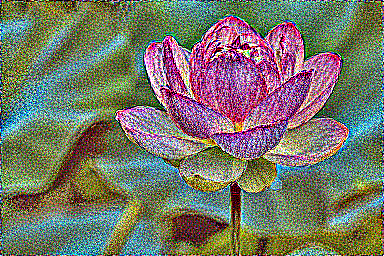

In [ ]:
view(noise)

Agregar estilo

In [ ]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()
    loss = perceptual_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item():.3f}"
    loss.backward()
    optimizer.step()

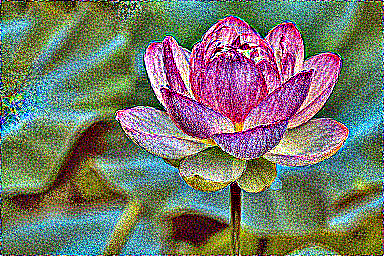

In [ ]:
view(noise)

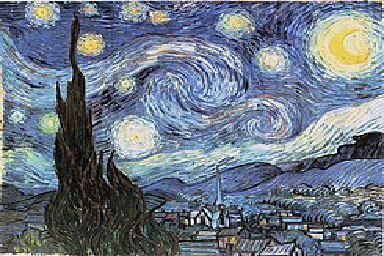

In [ ]:
style = fv.PILImage.create("Foto1.jpg").resize(size)
style

In [ ]:
style_tensor = Normalize()(to_tensor(style)).cuda()

In [ ]:
style_tensor

tensor([[[[ 2.0605,  2.0605,  2.1975,  ...,  1.8722,  1.5982,  1.5982],
          [-0.7993, -0.7993, -1.1075,  ...,  0.2796,  2.2489,  2.2489],
          [-0.7993, -0.7993, -1.1075,  ...,  0.2796,  2.2489,  2.2489],
          ...,
          [ 1.1358,  1.1358,  0.6563,  ..., -0.0116,  1.6495,  1.6495],
          [ 1.1358,  1.1358,  0.6563,  ..., -0.0116,  1.6495,  1.6495],
          [ 1.6324,  1.6324,  2.1975,  ..., -1.0904,  1.1872,  1.1872]],

         [[ 2.2885,  2.2885,  2.4286,  ...,  1.6583,  1.3256,  1.3256],
          [-0.6352, -0.6352, -0.9503,  ...,  0.2227,  2.1835,  2.1835],
          [-0.6352, -0.6352, -0.9503,  ...,  0.2227,  2.1835,  2.1835],
          ...,
          [ 1.2206,  1.2206,  0.6954,  ...,  0.1702,  1.7983,  1.7983],
          [ 1.2206,  1.2206,  0.6954,  ...,  0.1702,  1.7983,  1.7983],
          [ 1.6933,  1.6933,  2.2360,  ..., -0.9328,  1.3256,  1.3256]],

         [[ 2.5877,  2.5877,  2.6400,  ...,  1.1934,  0.6008,  0.6008],
          [-0.2881, -0.2881, -

In [ ]:
def gram_matrix(x):
    bs, c, h,w = x.shape
    x = x.view(bs, c, h*w)
    return (x@x.transpose(1,2))/(c*h*w)

In [ ]:
class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weights = [1,3,8,12,20,10], style_weights = [20,25,15,10,4], style_mult=8e3):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.style_mult = style_mult
        
    def extract_features(self, x, clone = False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a, b, w in zip(A, B, self.style_weights)])
    
    def forward(self, x, content_image, style_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone = True)
        style_features = self.extract_features(style_image, clone = True)
        
        self.CL = self.content_loss(x_features, content_features)
        self.SL = self.style_mult*self.style_loss(x_features, style_features)
        return self.CL + self.SL
    
    def __del__(self):
        self.hooks.remove()

In [ ]:
def style_content_loss(**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,o in enumerate(vgg.children()) if isinstance(o, nn.MaxPool2d)]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks, **kwargs)

In [ ]:
content_and_style_loss = style_content_loss().cuda()

In [ ]:
optimizer = torch.optim.Adam([noise], lr = 1e-1)

In [ ]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.3f} | style_loss = {content_and_style_loss.SL:.2f} | total_loss = {loss.item():.2f}"
    loss.backward()
    optimizer.step()

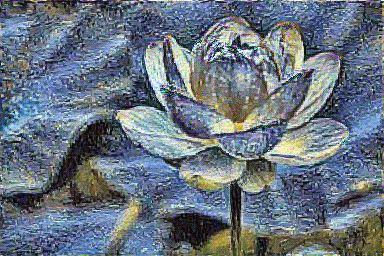

In [ ]:
view(noise)

Optimización. Desde el inicio se guardan las features de la imagen y el estilo

In [ ]:
class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weights = [1,3,8,12,20,10],style_weights = [20,25,15,10,4], style_mult=8e3, content_image=[None,None,None,None,None,None], content_style=[None,None,None,None]):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.style_mult = style_mult
        self.image_features = self.extract_features(content_image,clone = True)
        self.style_features = self.extract_features(content_style, clone = True)
        
    def extract_features(self, x, clone = False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a, b, w in zip(A, B, self.style_weights)])
    
    def forward(self, x):
        x_features = self.extract_features(x)
        
        self.CL = self.content_loss(x_features, self.content_features)
        self.SL = self.style_mult*self.style_loss(x_features, self.style_features)
        return self.CL + self.SL
    
    def __del__(self):
        self.hooks.remove()

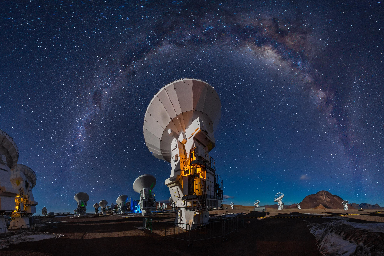

In [ ]:
style2 = fv.PILImage.create("observatorio-alma-chile (2).jpg").resize(size)
style2

In [ ]:
style2_tensor = Normalize()(to_tensor(style2)).cuda()

In [ ]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, content_tensor, style2_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.3f} | style_loss = {content_and_style_loss.SL:.2f} | total_loss = {loss.item():.2f}"
    loss.backward()
    optimizer.step()

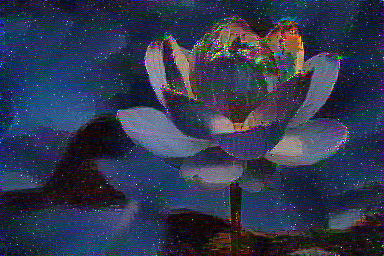

In [ ]:
view(noise)

De aquí en adelante solo prové las visualizaciones XD

In [ ]:
noise = torch.randn_like(content_tensor, requires_grad = True)

In [ ]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

In [ ]:
pbar = progress_bar(range(5000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, style2_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.3f} | style_loss = {content_and_style_loss.SL:.2f} | total_loss = {loss.item():.2f}"
    loss.backward()
    optimizer.step()


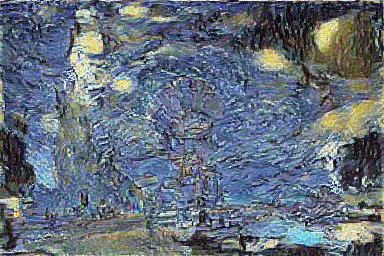

In [ ]:
view(noise)

In [ ]:
noise = torch.randn_like(content_tensor, requires_grad = True)

In [ ]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

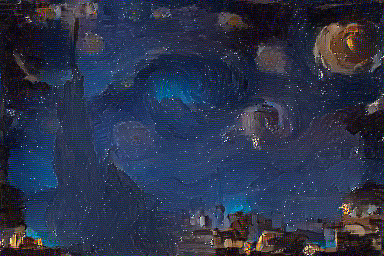

In [ ]:
pbar = progress_bar(range(5000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, style_tensor, style2_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.3f} | style_loss = {content_and_style_loss.SL:.2f} | total_loss = {loss.item():.2f}"
    loss.backward()
    optimizer.step()
view(noise)

Despues de esto vi que se trabaja bajo la misma imagen de ruido, así que para trabajar en distintas imagenes es necesario crear de nuevo la imagen de ruido y el optimizador pero me gustaron los primeros resultados